# Preprocess Legionella Data & PPI to Form GCN Input
In this notebook, I want to join the PPI network from ConsensusPathDB, the gene expression derived from the dual RNA-seq experiments and the labels to form one dataset. The goal is a hdf5 container with all the information to train a GCN on the data.

This involves the following steps:
* Preprocess the gene expression data
* Calculate an adjacency matrix from the protein-protein-interactions
* Only use genes in network for which we have gene expression
* Check if the node degree follows a power law distribution
* Load the labels and split into training and testing
* Create hdf5 container

In [3]:
import pandas as pd
import numpy as np
#from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True)
import h5py
import mygene
from sklearn.model_selection import train_test_split
%matplotlib inline

## Parameters for the Notebook
* **TIMES_STD_THRESHOLD:** How many times over the standard deviation does a gene have to show expression to be considered as an outlier.
* **MAX_ZEROS_ALLOWED:** The ratio of zeros of gene expressions for a gene that is permitted before the gene gets kicked out.
* **SCALE:** Do we normalize the gene expression using a standard min/max scaler?
* **VAL_SIZE:** The size of our validation data set (0 means no validation data set).
* **TEST_RATIO:** The ratio of the data that is used for testing the model.

In [4]:
# params
TIMES_STD_THRESHOLD = 10.
MAX_ZEROS_ALLOWED = .7
SCALE = False
VAL_SIZE = 0
TEST_RATIO = 0.4

## Preprocess Gene Expression
Let's start by preprocessing the gene expression values. We have the counts already normalized, which is good. But we might want to kick out those genes that show a unrealistically high gene expression or that do contain lots of zeros.

In [5]:
# load data
gene_expression = pd.DataFrame.from_csv('../data/preprocessing/normalized-counts-labels.csv',
                                        encoding='utf-8', sep=','
                                       )
ge_nonames = gene_expression.drop('Name', axis=1)

# kick out super highly expressed genes
threshold = ge_nonames.mean(axis=1).std()*TIMES_STD_THRESHOLD
#print ("Threshold Gene Expression: {}".format(threshold))
anomalies = gene_expression[ge_nonames.mean(axis=1) > threshold]
ge_anomalies_removed = ge_nonames.drop(anomalies.index)

# kick out genes with too many zeros
ge_zeros_removed = ge_anomalies_removed[ge_anomalies_removed.astype('bool').mean(axis=1)>=(1-MAX_ZEROS_ALLOWED)]

# write gene expression to file to perform differential expression analysis on it
ge_zeros_removed.to_csv('../data/preprocessing/gene_expression_counts.tsv', sep='\t')

# scaling
if SCALE:
    scaler = preprocessing.StandardScaler()
    scaled_features = scaler.fit_transform(ge_zeros_removed)
    ge_final = pd.DataFrame(scaled_features,
                            index=ge_zeros_removed.index,
                            columns=ge_zeros_removed.columns
                           )
else:
    ge_final = ge_zeros_removed

# print some information
print ("Had gene expression for {} genes in the beginning.".format(ge_nonames.shape[0]))
print ("kicked out {} super highly expressed genes".format(ge_nonames.shape[0] - ge_anomalies_removed.shape[0]))
print ("Kicked out {} genes with more than {}% zeros".format(ge_anomalies_removed.shape[0]-ge_zeros_removed.shape[0],
                                                             MAX_ZEROS_ALLOWED*100.
                                                            ))
print ("==> Left with gene expression for {} genes".format(ge_final.shape[0]))

Had gene expression for 41424 genes in the beginning.
kicked out 9 super highly expressed genes
Kicked out 11344 genes with more than 70.0% zeros
==> Left with gene expression for 30071 genes


In [6]:
gene_names = gene_expression.loc[ge_final.index].Name.values
gene_ids = ge_final.index
gene_expression.head()

,Name,Pam3T16,Pam3T8,Pam3T16.1,Pam3T8.1,Pam3T16.2,Pam3T8.2,ControlT8,ControlT16,ControlT8.1,...,gfpmT8.1,gfpmT16.1,gfpmT8.2,gfpmT16.2,gfppT8,gfppT16,gfppT8.1,gfppT16.1,gfppT8.2,gfppT16.2
Ensembl-ID,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,TSPAN6,6.736327,8.519666,10.773706,10.813725,2.427830,7.425264,9.417385,7.920964,10.812953,...,12.529836,6.769370,13.440488,5.248289,14.583375,13.538040,18.220493,14.908853,16.156797,30.745221
ENSG00000000419,DPM1,97.676739,73.025712,132.362676,110.840686,87.401897,87.865624,92.725018,105.132797,121.218890,...,127.983328,147.421826,104.163784,86.596770,298.959192,239.172041,268.101547,155.611158,283.898001,247.298513
ENSG00000000457,SCYL3,84.204085,74.242807,61.564035,68.486928,78.499852,92.815800,86.929705,72.728852,66.585024,...,76.074006,63.180782,117.604272,94.469203,83.125239,79.724014,76.786365,62.430824,85.400212,93.572410
ENSG00000000460,C1orf112,61.468982,48.683808,70.798641,63.080065,63.123592,76.727728,68.819350,68.408327,77.397977,...,56.384263,72.958761,81.482960,51.608176,24.791738,33.092987,29.933668,59.635414,30.005480,26.734974
ENSG00000000938,FGR,53.890614,150.919804,143.136382,362.259802,156.999704,160.880721,62.299622,61.207450,189.511222,...,333.830638,257.988195,186.486774,70.851902,129.792040,97.774734,272.005939,245.996082,140.794944,101.592903


## ConsensusPathDB: Get PPI Network
I want to construct an adjacency matrix from the interactions in ConsensusPathDB.
However, I only want it for the genes for which I have gene expression data. If not both genes are involved in an interaction, I don't want to save the interaction.

In [7]:
# read interaction data (implicit threshold of 0.5 for interaction confidence)
interactions = pd.read_csv('../data/networks/CPDB_ensg_edgelist.tsv',
                           header=0,
                           sep='\t',
                           names=['number', 'gene1', 'gene2', 'score']
                          )

# kick out interactions for which we don't have gene expression
lost = interactions[~interactions.gene1.isin(ge_final.index) | ~interactions.gene2.isin(ge_final.index)].shape[0]
print ("We lose {} interactions by removing those where not both genes have expression".format(lost))
interactions_ge = interactions[interactions.gene1.isin(ge_final.index) & interactions.gene2.isin(ge_final.index)]
print ("Still keeping {} interactions".format(interactions_ge.shape[0]))

We lose 53664 interactions by removing those where not both genes have expression
Still keeping 164708 interactions


In [8]:
# construct adjacency matrix (memory consuming)
ppi_network = interactions_ge.pivot('gene1', 'gene2', 'score')
ppi_network[~ppi_network.isnull()] = 1
ppi_network[ppi_network.isnull()] = 0

# add genes for which no interactions are present
index = ppi_network.index.union(ppi_network.columns)
ppi_network = ppi_network.reindex(index=index, columns=index, fill_value=0)

# output some statistics
avg_node_degree = ppi_network.sum().mean()
total_num_of_connections = ppi_network.sum().sum()

print ("Constructed Adjacency Matrix with average node degree of: {}".format(avg_node_degree))
print ("Adjacency matrix has {} edges in total".format(total_num_of_connections))
print ("Network has {} nodes in total".format(ppi_network.index.shape[0]))

Constructed Adjacency Matrix with average node degree of: 15.218331331423819
Adjacency matrix has 164708.0 edges in total
Network has 10823 nodes in total


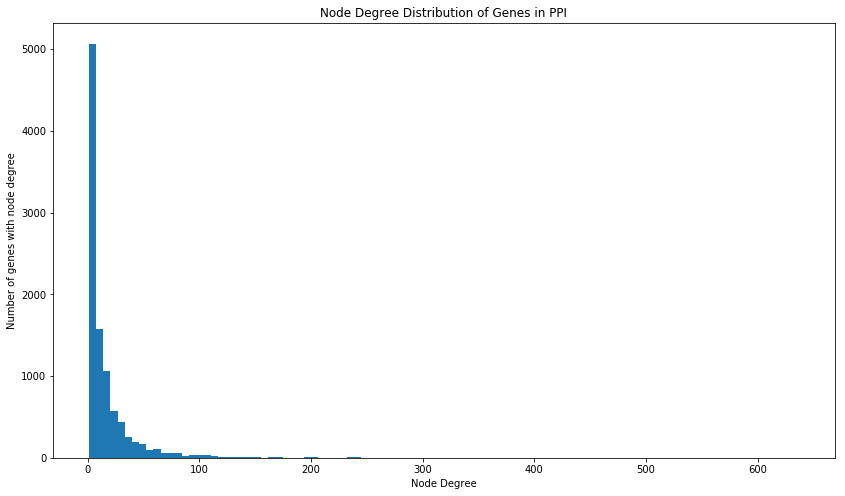

In [9]:
# plot node degree to check if distribution follows power law
node_degrees = ppi_network.sum()
fig = plt.figure(figsize=(14, 8))
bins = np.linspace(1,node_degrees.max(), 100)
ax = plt.hist(node_degrees, bins)
plt.xlabel('Node Degree')
plt.ylabel('Number of genes with node degree')
plt.title('Node Degree Distribution of Genes in PPI')

## Remove isolated genes from network & gene expression
Genes that have no interactions reported are not relevant for any network algorithm. I can kick out those genes for now.

In [10]:
# kick out all genes without interactions (isolated nodes)
genes_with_interactions = ppi_network.sum(axis=1) > 0
ppi_network = ppi_network.ix[genes_with_interactions, genes_with_interactions]
print (ppi_network.shape)

# build list of gene names and ids
gene_names_ids = ppi_network.join(gene_expression['Name']).Name
gene_names_ids = pd.DataFrame(gene_names_ids)
gene_names_ids = np.vstack([gene_names_ids.index, gene_names_ids.Name])
gene_names_ids = gene_names_ids.transpose(1, 0)

# remove gene expression for isolated genes
gene_expression_short = ge_final[ge_final.index.isin(ppi_network.index)]

(9991, 9991)


## Load the Labels and Do Train Test Split
Finally, I want to load the labels that I obtained by literature search and that I got from Wigo.
Once loaded and joined, I derive one big dataframe with a label column to make sure they are in the same order as the rest of the data, especially the PPI network.
Then, I calculate train and test splits (**but I have to be careful because of the extremely high class imbalance**).
And last but not least, I have to build the training and testing masks that are needed by the GCN algorithm.

In [85]:
def build_mask(names_labeled, X):
    mask = names_labeled[names_labeled.isin(X)].label
    # NaN means not being in the set
    mask[~mask.isnull()] = 1
    mask[mask.isnull()] = 0
    # sanity check
    assert (np.all(mask.index == gene_names_ids[:, 0]))
    return mask.values

def build_y(names_labeled, X):
    y = names_labeled[names_labeled.isin(X)].label
    # NaN means not being in the set
    y[y.isnull()] = 0
    # sanity check
    assert (np.all(y.index == gene_names_ids[:, 0]))
    y_onehot = pd.get_dummies(y).values
    return y_onehot[:, [1,0]] # switch the positive and negative columns

def balanced_stratified_split(X, test_ratio):
    # calculate number of labels for both sets
    num_labels_total = X.label.sum()
    num_labels_train = int(num_labels_total * (1-test_ratio))
    num_labels_test = num_labels_total - num_labels_train
    # select random training set (size 2*num_labels_train)
    X_train = X[X.label].sample(n=num_labels_train).append(X[~X.label].sample(n=num_labels_train))
    # rest is test
    X_test = X[~X.index.isin(X_train.index)]
    return X_train, X_test
    

In [86]:
# load the labels from Wigos list and my literature search (together with Wigos extension)
infection_genes = pd.DataFrame.from_csv('../data/labels/labels_wigo_codingonly.csv', sep='\t', index_col=3)
my_infection_genes = pd.DataFrame.from_csv('../data/labels/labels_wigo_extended.tsv',
                                           sep='\t',
                                           index_col=1
                                          )
infection_genes = infection_genes.append(my_infection_genes)
print ("Collected {} genes involved in legionella infection".format(infection_genes.shape[0]))

# load the gene names and add label column to it
gene_names_df = pd.DataFrame(gene_names_ids,
                             index=gene_names_ids[:, 0],
                             columns=['ID', 'name']
                            ).drop('ID', axis=1)
names_labeled = gene_names_df
names_labeled['label'] = gene_names_df.index.isin(infection_genes.index)
print ("Out of the {} infection genes, {} are in the network".format(infection_genes.shape[0],
                                                                     names_labeled.label.sum())
      )

# split for training, testing & validation
X_train, X_test = balanced_stratified_split(names_labeled, TEST_RATIO)
if VAL_SIZE > 0:
    X_val = X_train[-VAL_SIZE:]
    X_train = X_train[:-VAL_SIZE]
else:
    X_val = None
print ("Split Training and Testing with {}% test nodes".format(TEST_RATIO*100.))
print ("Training Nodes: {}\t# of Labels in Train Set: {}".format(X_train.shape[0],
                                                                 X_train.label.sum())
      )
print ("Testing Nodes: {}\t# of Labels in Test Set: {}".format(X_test.shape[0],
                                                               X_test.label.sum())
      )

# construct masks
train_mask = build_mask(names_labeled, X_train)
test_mask = build_mask(names_labeled, X_test)
if X_val is not None:
    val_mask = build_mask(features_labeled, X_val)

# construct labels
y_train = build_y(names_labeled, X_train)
y_test = build_y(names_labeled, X_test)
if X_val is not None:
    y_val = pd.get_dummies(features_labeled[features_labeled.isin(X_val)].label).values

Collected 46 genes involved in legionella infection
Out of the 46 infection genes, 37 are in the network
Split Training and Testing with 40.0% test nodes
Training Nodes: 44	# of Labels in Train Set: 22
Testing Nodes: 9947	# of Labels in Test Set: 15


## Write to hdf5 File on Disk
The last thing to do is to write the data to disk, using the fast and efficient hdf5 format.

In [87]:
# create gene names
string_dt = h5py.special_dtype(vlen=str)

f = h5py.File('../data/preprocessing/legionella_gcn_input.h5', 'w')
f.create_dataset('network', data=ppi_network, shape=ppi_network.shape)
f.create_dataset('features', data=gene_expression_short, shape=gene_expression_short.shape)
f.create_dataset('gene_names', data=gene_names_ids, dtype=string_dt)

f.create_dataset('y_train', data=y_train, shape=y_train.shape)
f.create_dataset('y_test', data=y_test, shape=y_test.shape)
if X_val is not None:
    f.create_dataset('y_val', data=y_val, shape=y_val.shape)

f.create_dataset('mask_train', data=train_mask, shape=train_mask.shape)
f.create_dataset('mask_test', data=test_mask, shape=test_mask.shape)
if X_val is not None:
    f.create_dataset('mask_val', data=val_mask, shape=val_mask.shape)
f.close()